In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
from tqdm.auto import tqdm, trange
from scipy import interpolate
from glob import glob
import re

from tio import Reader
from spefit import BinnedNLL, SiPMGentile, SiPMModifiedPoisson, minimize_with_iminuit, ChargeContainer

from sstcam_simulation import PhotoelectronSource, EventAcquisition, Camera
from sstcam_simulation.camera.spe import SiPMGentileSPE
from sstcam_simulation.camera.coupling import NoCoupling, ACFilterCoupling, ACOffsetCoupling
from sstcam_simulation.camera.pulse import GenericPulse
from sstcam_simulation.camera.noise import GaussianNoise
from sstcam_simulation.camera.mapping import SSTCameraMapping

%matplotlib inline

In [24]:
window_width = 10

def extract_charge(waveform, index):
    window_start = index - 5
    window_end = window_start + window_width
    return waveform[:, window_start:window_end].sum(1)

In [3]:
def fit_spe(charge):
    pdf = SiPMGentile(n_illuminations=1)
    pdf.update_parameters_limits(
        eped=(-20, 20), 
        eped_sigma=(0, 20),
        pe=(0, 50),
        pe_sigma=(0, 20),
    )
    pdf.update_parameters_initial(
        eped=-10., 
        eped_sigma=10,
        pe=30,
        pe_sigma=3.49,
        opct=0.4,
        lambda_=2.5,
    )
    container = ChargeContainer(charge, 100, (-50, 500))
    cost = BinnedNLL(pdf, [container])
    spe_values, spe_errors = minimize_with_iminuit(cost)

    values_array = np.array(list(spe_values.values()))
    fit_x = np.linspace(container.values.min(), container.values.max(), 1000)
    fit_y = pdf(fit_x, values_array, 0)

    plt.hist(container.between, weights=container.hist, bins=container.edges, histtype='step', density=True)
    plt.plot(fit_x, fit_y)
    
    return spe_values

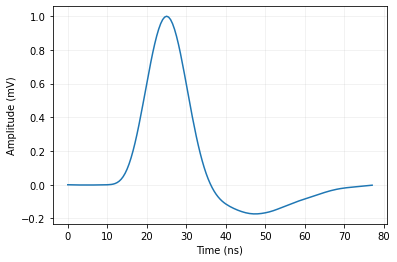

In [4]:
# Read pulse shape
# Load the pulse template
pulse_t, pulse_y = np.loadtxt("pulse_shape.txt", unpack=True)
pulse_t /= 1e-9  # Convert into ns

plt.plot(pulse_t, pulse_y)
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (mV)")
plt.grid(alpha=0.2)

In [5]:
# Extract ratio between integration and pulse height
f = interpolate.interp1d(pulse_t, pulse_y, kind=3)
ref_x = np.arange(0, pulse_t[-1], 1)
ref_y = f(ref_x)

height = ref_y.max()
argmax = ref_y.argmax()
charge = extract_charge(ref_y[None, :], argmax)[0]
height_ratio = height / charge
print(height_ratio)

0.11725625063758088


# Stage 1: Extract Parameters from SPE dataset

In [6]:
spe_path = "/Users/Jason/Current/d210220_nsb/PE_Spectrum_r1.tio"

  0%|          | 0/60021 [00:00<?, ?it/s]

[28 29 30 31] 37


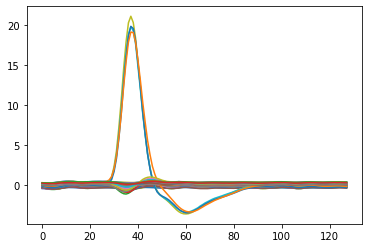

In [7]:
# Check where pulse is 

with Reader(spe_path) as reader:
    avg_wf = np.zeros((reader.n_pixels, reader.n_samples))
    for event in tqdm(reader, total=reader.n_events):
        avg_wf += event
    avg_wf /= reader.n_events
    
_ = plt.plot(avg_wf.T)
active_pixels = np.where(avg_wf.max(1) >= 5)[0]
ipix = active_pixels[1]
pulse_time = avg_wf[ipix].argmax()
print(active_pixels, pulse_time)

In [8]:
# Extract SPE charges

with Reader(spe_path) as reader:
    charge = np.zeros(reader.n_events)
    pedestal_stddev = np.zeros(reader.n_events)
    pedestal_sum = np.zeros(reader.n_events)
    for iev, event in tqdm(enumerate(reader), total=reader.n_events):
        charge[iev] = extract_charge(event, pulse_time)[ipix]
        pedestal_stddev[iev] = event[5].std()
        pedestal_sum[iev] = event[5].sum()

  0%|          | 0/60021 [00:00<?, ?it/s]

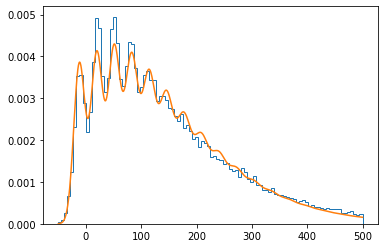

In [9]:
spe_values = fit_spe(charge)

In [10]:
# Data from lab SPE for input into simulation

pe_height = spe_values['pe'] * height_ratio  # mV
spe_sigma = spe_values['pe_sigma'] / spe_values['pe']
opct = spe_values['opct']
pedestal_stddev = pedestal_stddev.mean()
spe_illumination = spe_values['lambda_0']
print(pe_height, spe_sigma, opct, pedestal_stddev, spe_illumination)

3.6815951034997125 0.11125159924940045 0.5219999612752834 1.229288316270932 2.337305847198812


# Stage 2: Create Simulation Model

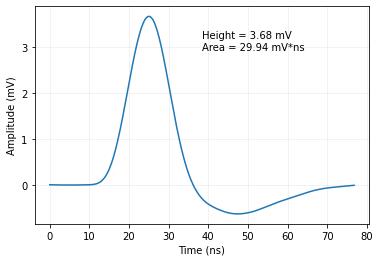

In [13]:
# Create the `GenericPulse` class and plot its contents
photoelectron_pulse = GenericPulse(pulse_t, pulse_y, mv_per_pe=pe_height)

plt.plot(photoelectron_pulse.time, photoelectron_pulse.amplitude)
plt.text(0.5, 0.8, f"Height = {photoelectron_pulse.height:.2f} mV\nArea = {photoelectron_pulse.area:.2f} mV*ns", transform=plt.gca().transAxes)
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (mV)")
plt.grid(alpha=0.2)

f.c. = Fired Microcells


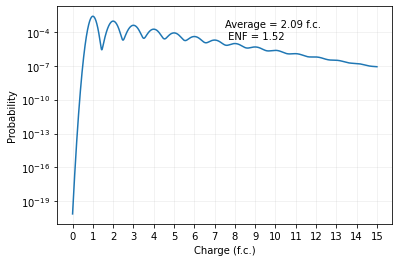

In [14]:
# Create the `SiPMGentileSPE` class and plot its contents
photoelectron_spectrum = SiPMGentileSPE(x_max=15, spe_sigma=spe_sigma, opct=opct, normalise_charge=False)
unit = "p.e." if photoelectron_spectrum.normalise_charge else "f.c."
plt.plot(photoelectron_spectrum.x, photoelectron_spectrum.pdf)
plt.text(0.5, 0.85, f"Average = {photoelectron_spectrum.average:.2f} {unit}\n ENF = {photoelectron_spectrum.excess_noise_factor:.2f}", transform=plt.gca().transAxes)
plt.yscale('log')
plt.xlabel(f"Charge ({unit})")
plt.ylabel("Probability")
loc = ticker.MultipleLocator(base=1.0)
plt.gca().xaxis.set_major_locator(loc)
plt.grid(alpha=0.2)
print("f.c. = Fired Microcells")

In [15]:
digitisation_noise = GaussianNoise(stddev=pedestal_stddev) # TODO
coupling = ACOffsetCoupling(nsb_rate=0, pulse_area=photoelectron_pulse.area, spectrum_average=photoelectron_spectrum.average)

camera = Camera(
    photoelectron_pulse=photoelectron_pulse,
    photoelectron_spectrum=photoelectron_spectrum,
    digitisation_noise=digitisation_noise,
    coupling=coupling,
    continuous_readout_duration=128,  # Only simulate 128 ns of readout per event
    n_waveform_samples=128,  # Similarly, only digitise 128 samples
    mapping=SSTCameraMapping(n_pixels=1),  # Simulate a camera with only 1 pixel
)

source = PhotoelectronSource(camera=camera)
acquisition = EventAcquisition(camera=camera)

In [16]:
# Simulate SPE measurement
n_events = 60000
charge = np.zeros(n_events)
avg_wf = np.zeros(128)
dark_count_rate = 27  # MHz
camera.coupling.update_nsb_rate(dark_count_rate)
for iev in trange(n_events):
    pe_laser = source.get_uniform_illumination(pulse_time, spe_illumination)
    pe_dark_counts = source.get_nsb(dark_count_rate)
    readout = acquisition.get_continuous_readout(pe_laser + pe_dark_counts)
    waveform = acquisition.get_sampled_waveform(readout)
    avg_wf += waveform[0]
    charge[iev] = extract_charge(waveform, pulse_time)[0]

  0%|          | 0/60000 [00:00<?, ?it/s]

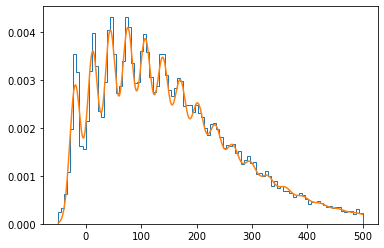

In [17]:
spe_values_simulation = fit_spe(charge)

In [18]:
print(spe_values)
print(spe_values_simulation)

{'eped': -11.682929433500188, 'eped_sigma': 10.12589719911303, 'pe': 31.397857969029698, 'pe_sigma': 3.493061912060086, 'opct': 0.5219999612752834, 'lambda_0': 2.337305847198812}
{'eped': -19.14600215884081, 'eped_sigma': 9.699771938481096, 'pe': 31.568928328497627, 'pe_sigma': 2.834556130981738, 'opct': 0.5159893550413727, 'lambda_0': 2.660554241463281}


# Stage 3: Investigate vs NSB

In [19]:
paths = glob("/Users/Jason/Current/d210220_nsb/NSB_*_MHz_r1.tio")
pattern = r"(?:.+)NSB_(\d+)_MHz_r1.tio"
d_list = []
for path in tqdm(paths):
    nsb = int(re.search(pattern, path).group(1))
    with Reader(path) as reader:
        for event in reader:
            charge = extract_charge(event, pulse_time)[ipix]
            d_list.append(dict(
                nsb=nsb,
                charge=charge,
            ))      
df_lab = pd.DataFrame(d_list)

  0%|          | 0/20 [00:00<?, ?it/s]

In [20]:
# Simulation
n_events = 10000
d_list = []
nsb_levels = np.unique(df_lab['nsb'])
for nsb in tqdm(nsb_levels):
    camera.coupling.update_nsb_rate(nsb)
    for ievent in range(n_events):
        pe = source.get_nsb(nsb)
        readout = acquisition.get_continuous_readout(pe)
        waveform = acquisition.get_sampled_waveform(readout)
        charge = extract_charge(waveform, pulse_time)[0]
        d_list.append(dict(
            nsb=nsb,
            charge=charge,
        ))
df_simulation = pd.DataFrame(d_list)

  0%|          | 0/20 [00:00<?, ?it/s]

In [21]:
def convert_mv_to_pe(charge_integral):
    charge_mv = charge_integral * height_ratio
    fc_per_pe = camera.photoelectron_spectrum.average
    mv_per_fc = camera.photoelectron_pulse.height
    mv_per_pe = mv_per_fc * fc_per_pe
    return charge_mv / mv_per_pe

In [22]:
df_lab['charge_calib'] = convert_mv_to_pe(df_lab['charge'].values)
df_simulation['charge_calib'] = convert_mv_to_pe(df_simulation['charge'].values)

In [25]:
# Prediction
enf = camera.photoelectron_spectrum.excess_noise_factor
pedestal_stddev_pe = convert_mv_to_pe(pedestal_stddev)

sigma_prediction = np.sqrt(window_width * (nsb_levels * 1e-3 * enf + pedestal_stddev_pe**2))

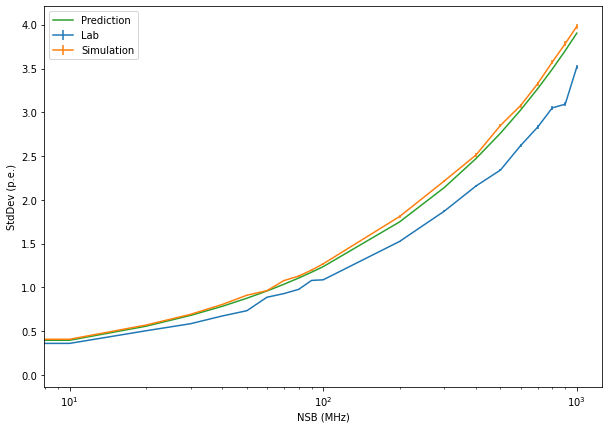

In [26]:
fig, ax = plt.subplots(figsize=(10, 7))

df_std = df_lab.groupby('nsb').std()
x = df_std.index.values
std = df_std['charge_calib'].values
yerr = std / np.sqrt(2 * n_events - 1)
ax.errorbar(x, std, yerr=yerr, label="Lab")

df_std = df_simulation.groupby('nsb').std()
x = df_std.index.values
std = df_std['charge_calib'].values
yerr = std / np.sqrt(2 * n_events - 1)
ax.errorbar(x, std, yerr=yerr, label="Simulation")

ax.plot(nsb_levels, sigma_prediction, label="Prediction")

ax.set_xscale('log')
ax.set_xlabel("NSB (MHz)")
ax.set_ylabel("StdDev (p.e.)")
ax.legend()